# Employee Promotion Prediction: Organized Notebook

## 1. Introduction and Setup

Requires downloading employee_promotion.csv from this [link](https://www.kaggle.com/datasets/muhammadimran112233/employees-evaluation-for-promotion/code)

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

## 2. Data Description and Preprocessing

### Loading dataset & data.head()

In [ ]:
# Load dataset into a Pandas DF
data = pd.read_csv('employee_promotion.csv')
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73.0,0


### Visualizing initial dataset

In [ ]:
print("Shape of the dataset:", data.shape)

Shape of the dataset: (54808, 13)


In [ ]:
print("\nData types of each column:\n", data.dtypes)


Data types of each column:
 employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
awards_won                int64
avg_training_score      float64
is_promoted               int64
dtype: object


In [ ]:
print("\nDescriptive statistics:\n", data.describe())


Descriptive statistics:
         employee_id  no_of_trainings           age  previous_year_rating  \
count  54808.000000     54808.000000  54808.000000          50684.000000   
mean   39195.830627         1.253011     34.803915              3.329256   
std    22586.581449         0.609264      7.660169              1.259993   
min        1.000000         1.000000     20.000000              1.000000   
25%    19669.750000         1.000000     29.000000              3.000000   
50%    39225.500000         1.000000     33.000000              3.000000   
75%    58730.500000         1.000000     39.000000              4.000000   
max    78298.000000        10.000000     60.000000              5.000000   

       length_of_service    awards_won  avg_training_score   is_promoted  
count       54808.000000  54808.000000        52248.000000  54808.000000  
mean            5.865512      0.023172           63.712238      0.085170  
std             4.265094      0.150450           13.521910      

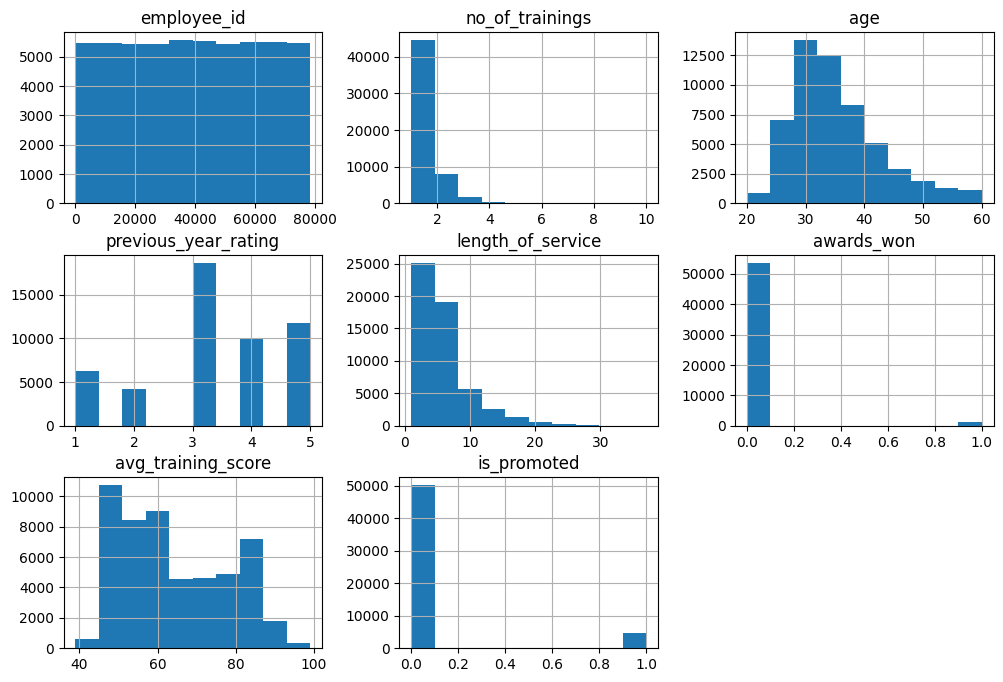

In [ ]:
# histogram
data.hist(figsize=(12, 8))
plt.show()

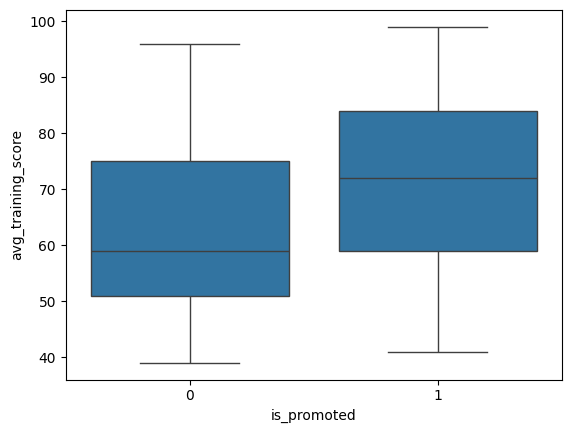

In [ ]:
# avg_training_score correlation boxplot
sns.boxplot(x='is_promoted', y='avg_training_score', data=data)
plt.show()

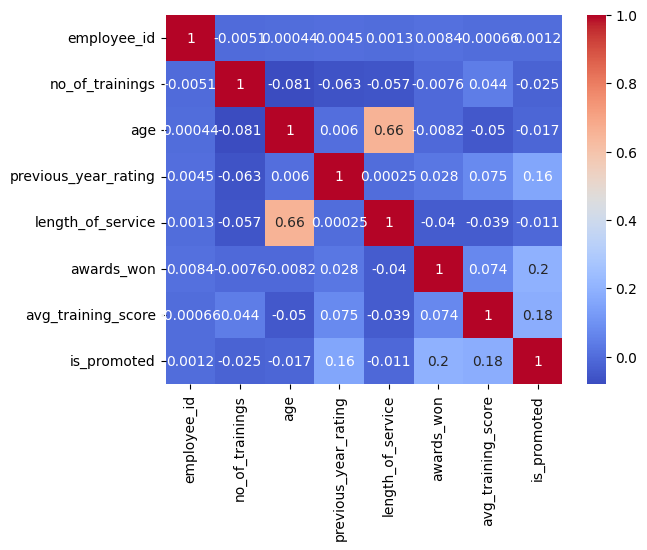

In [ ]:
# all variable correlation matrix
correlation_matrix = data.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

## 3. Feature Engineering and Transformation

### Handling Missing Values

In [ ]:
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
awards_won                 0
avg_training_score      2560
is_promoted                0
dtype: int64


### Imputing Missing Values
* Missing values in avg_training_score and previous_year_rating were imputed with the median to preserve data distribution and avoid outlier influence.
* For education, missing values were filled with the most common category to minimize bias in the categorical feature.

In [ ]:
imputer_median = SimpleImputer(strategy='median')
imputer_mode = SimpleImputer(strategy='most_frequent')

data['previous_year_rating'] = imputer_median.fit_transform(data[['previous_year_rating']])
data['education'] = imputer_mode.fit_transform(data['education'].values.reshape(-1, 1))[:, 0]
data['avg_training_score'] = imputer_median.fit_transform(data[['avg_training_score']])

In [ ]:
print("\nMissing Values After Imputation:")
print(data.isnull().sum())


Missing Values After Imputation:
employee_id             0
department              0
region                  0
education               0
gender                  0
recruitment_channel     0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
awards_won              0
avg_training_score      0
is_promoted             0
dtype: int64


### Encoding categorical variables using Label Encoding


In [ ]:
# storing label encoders
label_encoders = {}

# looping through categorical columns
for column in ['department', 'region', 'education', 'gender', 'recruitment_channel']:
    le = LabelEncoder() # creating a new LabelEncoder instance
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

### Splitting Dataset into Test and Train (80-20 split; 80% used for Training, 20% for Testing)

In [ ]:
X = data.drop(columns=['employee_id', 'is_promoted']) # feature set - dropping unnecessary columns (employee_id: identifier; is_promoted: target variable)
y = data['is_promoted'] # is_promoted: target variable

# splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaling numerical features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 4. Feature Selection

In [ ]:
# initialize models
gbc = GradientBoostingClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
lgbm = LGBMClassifier(random_state=42)

# dictionary to store models
models = {
    'GradientBoosting': gbc,
    'AdaBoost': ada,
    'LightGBM': lgbm
}

# dictionary to store results
results = {}

# loop through each model
for model_name, model in models.items():
    print(f"Processing {model_name}...")
    n_features = []
    accuracies = []

    # looping through different numbers of features
    for i in range(1, X_train.shape[1] + 1):
        rfe = RFE(estimator=model, n_features_to_select=i) # performing RFE
        rfe.fit(X_train, y_train) # fitting RFE onto training data

        # selecting features chosen by RFE
        X_train_selected = X_train[:, rfe.support_]
        X_test_selected = X_test[:, rfe.support_]

        model.fit(X_train_selected, y_train)
        y_pred = model.predict(X_test_selected) # making predictions on test set
        accuracy = accuracy_score(y_test, y_pred)

        n_features.append(i) # storing # of features
        accuracies.append(accuracy) # storing accuracy

    results[model_name] = {'n_features': n_features, 'accuracies': accuracies} # storing results

Processing GradientBoosting...
Processing AdaBoost...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

Processing LightGBM...
[LightGBM] [Info] Number of positive: 3760, number of negative: 40086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 43846, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085755 -> initscore=-2.366608
[LightGBM] [Info] Start training from score -2.366608
[LightGBM] [Info] Number of positive: 3760, number of negative: 40086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002387 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209
[LightGBM] [Info] Number of data points in the train set: 43846, number of used features: 10

### Accuracy vs Number of Features using Recursive Feature Elimination


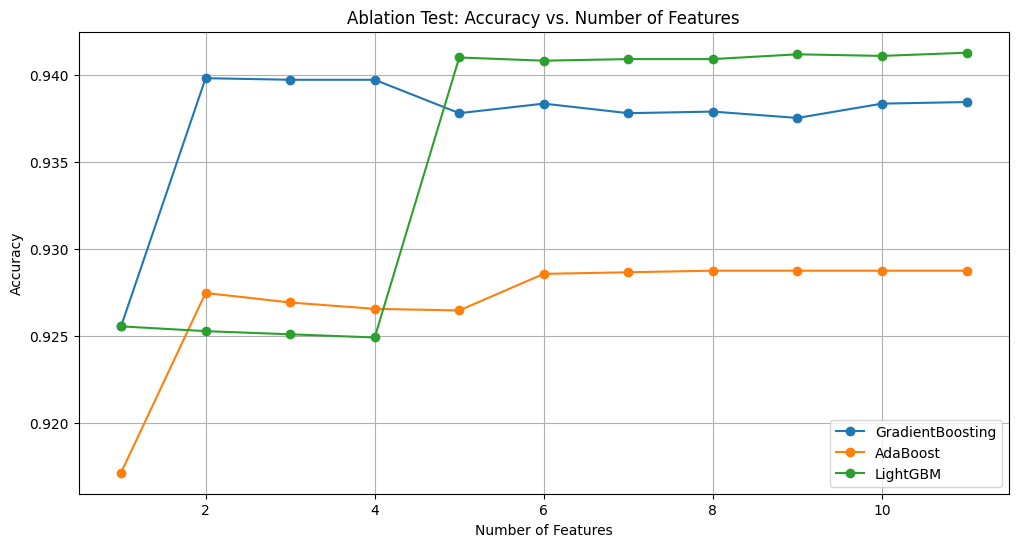

In [ ]:
# Plot ablation test results for each model
plt.figure(figsize=(12, 6))
for model_name, data in results.items():
    plt.plot(data['n_features'], data['accuracies'], marker='o', label=model_name)

plt.title('Ablation Test: Accuracy vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# optimal number of features for each model
for model_name, data in results.items():
    optimal_n_features = data['n_features'][np.argmax(data['accuracies'])]
    print(f"Optimal number of features for {model_name}: {optimal_n_features}")

Optimal number of features for GradientBoosting: 2
Optimal number of features for AdaBoost: 8
Optimal number of features for LightGBM: 11


### Top X Features of the Model


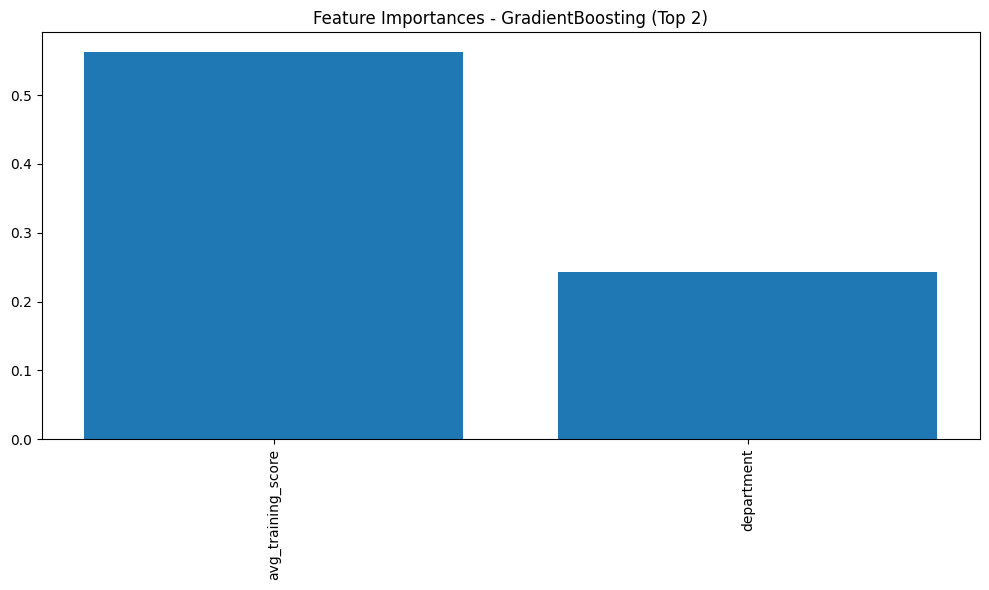

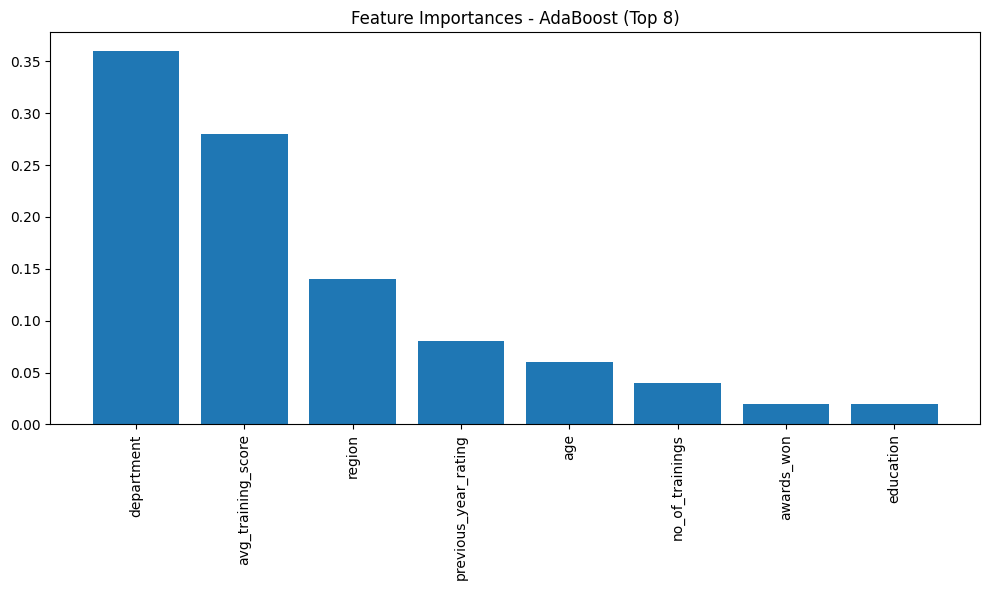

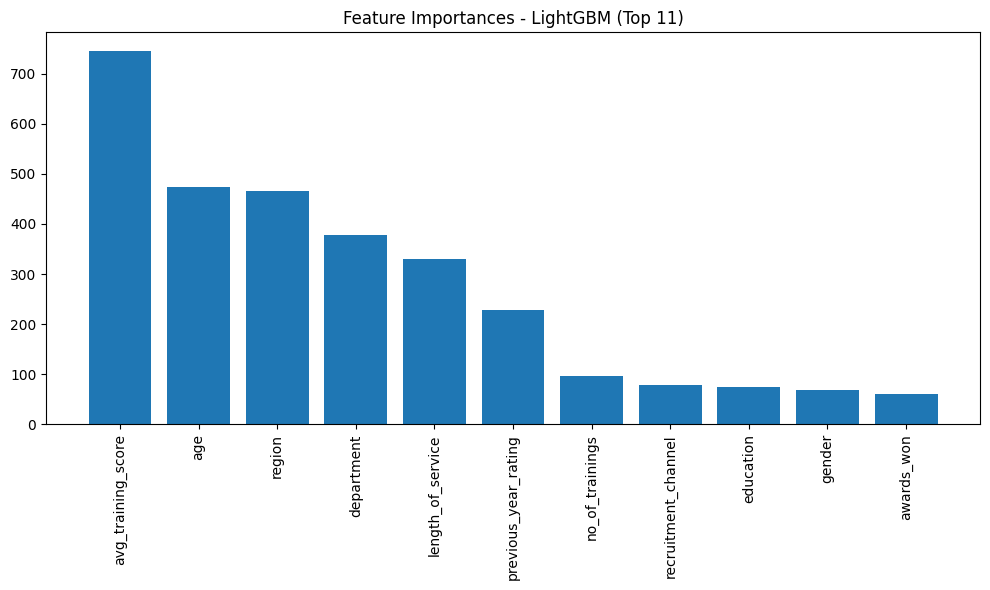

Important features for GradientBoosting: ['avg_training_score', 'department']
Important features for AdaBoost: ['department', 'avg_training_score', 'region', 'previous_year_rating', 'age', 'no_of_trainings', 'awards_won', 'education']
Important features for LightGBM: ['avg_training_score', 'age', 'region', 'department', 'length_of_service', 'previous_year_rating', 'no_of_trainings', 'recruitment_channel', 'education', 'gender', 'awards_won']


In [ ]:
# (model, optimal_n_features)
models = {
    'GradientBoosting': (gbc, 2),
    'AdaBoost': (ada, 8),
    'LightGBM': (lgbm, 11)
}

important_features = {}

for model_name, (model, optimal_n_features) in models.items():

    feature_importances = model.feature_importances_

    # descending order
    indices = np.argsort(feature_importances)[::-1]

    top_k_indices = indices[:optimal_n_features]
    top_k_features = X.columns[top_k_indices]

    # store important features for the current model
    important_features[model_name] = top_k_features

    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importances - {model_name} (Top {optimal_n_features})")
    plt.bar(range(optimal_n_features), feature_importances[top_k_indices], align="center")
    plt.xticks(range(optimal_n_features), top_k_features, rotation=90)
    plt.tight_layout()
    plt.show()

for model_name, features in important_features.items():
    print(f"Important features for {model_name}: {features.tolist()}")

## 5. Model Building and Evaluation

### Baseline Models with Default Thresholds (0.5)

Training GradientBoosting with optimal features...


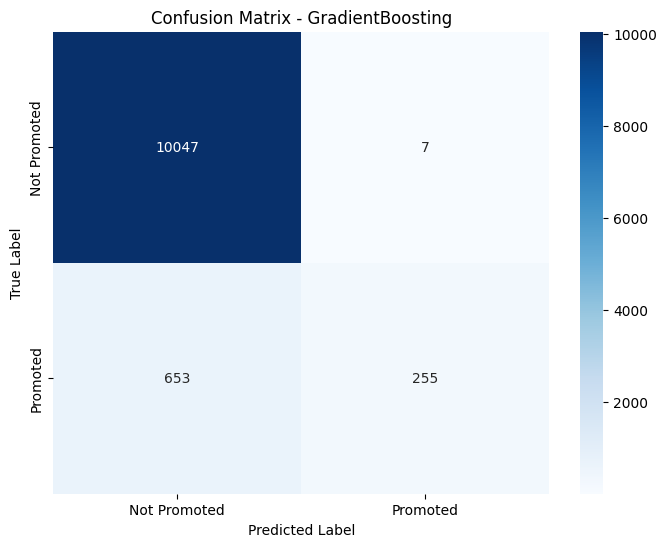

Training AdaBoost with optimal features...


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


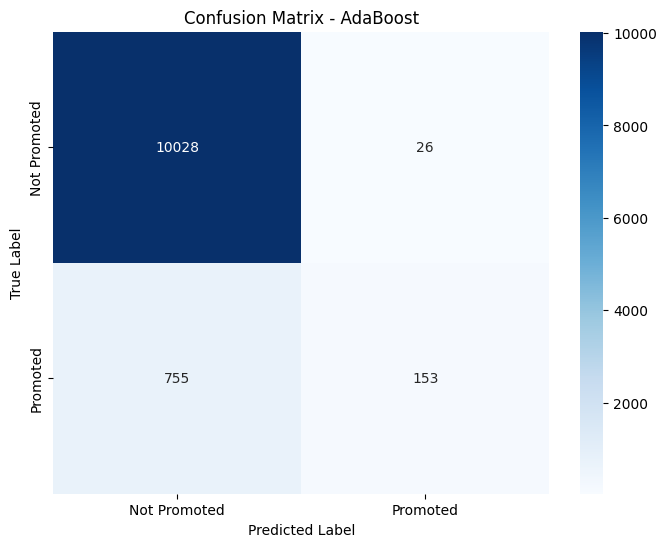

Training LightGBM with optimal features...
[LightGBM] [Info] Number of positive: 3760, number of negative: 40086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 43846, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085755 -> initscore=-2.366608
[LightGBM] [Info] Start training from score -2.366608


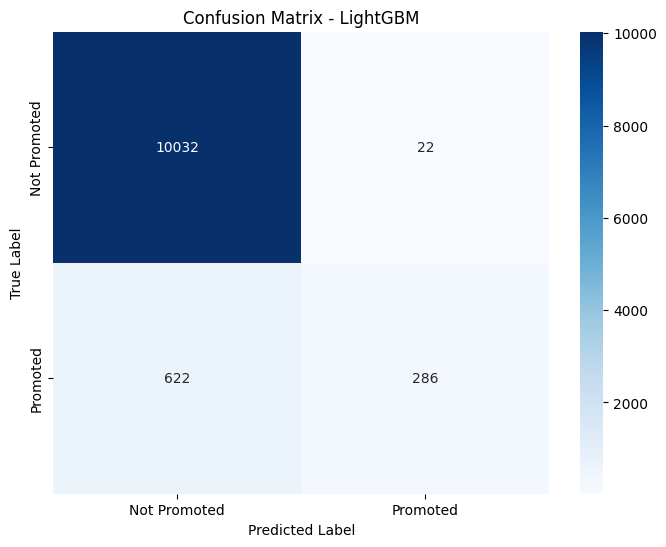


Model Evaluation Results:
--- GradientBoosting (Default Threshold)---
Accuracy: 0.9398
Precision: 0.9733
Recall: 0.2808
F1-Score: 0.4359

Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97     10054
           1       0.97      0.28      0.44       908

    accuracy                           0.94     10962
   macro avg       0.96      0.64      0.70     10962
weighted avg       0.94      0.94      0.92     10962



--- AdaBoost (Default Threshold)---
Accuracy: 0.9288
Precision: 0.8547
Recall: 0.1685
F1-Score: 0.2815

Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96     10054
           1       0.85      0.17      0.28       908

    accuracy                           0.93     10962
   macro avg       0.89      0.58      0.62     10962
weighted avg       0.92      0.93      0.91     10962



--- LightGBM (Default Threshold)---
Accuracy: 0.941

In [ ]:
scaler = StandardScaler()

# scaling training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# dictionary for models and optimal features
models_and_features = {
    'GradientBoosting': (GradientBoostingClassifier(random_state=42), ['avg_training_score', 'department']),
    'AdaBoost': (AdaBoostClassifier(random_state=42), ['department', 'avg_training_score', 'region', 'previous_year_rating', 'age', 'no_of_trainings', 'awards_won', 'education']),
    'LightGBM': (LGBMClassifier(random_state=42), ['avg_training_score', 'age', 'region', 'department', 'length_of_service', 'previous_year_rating', 'no_of_trainings', 'recruitment_channel', 'education', 'gender', 'awards_won'])
}

# dictionary for results
results = {}

for model_name, (model, features) in models_and_features.items():
    print(f"Training {model_name} with optimal features...")

    # use optimal features
    X_train_selected = X_train[:, X.columns.get_indexer(features)]
    X_test_selected = X_test[:, X.columns.get_indexer(features)]

    # train model on optimal features
    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)

    # evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # classification report and confusion matrix
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # storing results
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'classification_report': report,
        'confusion_matrix': cm
    }

    # confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Not Promoted', 'Promoted'],
                yticklabels=['Not Promoted', 'Promoted'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# printing results
print("\nModel Evaluation Results:")
for model_name, metrics in results.items():
    print(f"--- {model_name} (Default Threshold)---")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1-Score: {metrics['f1']:.4f}")
    print("\nClassification Report:\n", metrics['classification_report'])  # Include classification report
    print("\n")

### Hyperparameter Tuning

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

model = lgb.LGBMClassifier(random_state=42) # random state for reproducibility

# parameter grid
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# optimal features for training and testing
features = ['avg_training_score', 'age', 'region', 'department', 'length_of_service', 'previous_year_rating', 'no_of_trainings', 'recruitment_channel', 'education', 'gender', 'awards_won']
X_train_selected = X_train[:, X.columns.get_indexer(features)]
X_test_selected = X_test[:, X.columns.get_indexer(features)]

# tuning hyperparameter by fitting RandomizedSearchCV on training data
random_search.fit(X_train_selected, y_train)

# defining best model & best hyperparameters found
best_model = random_search.best_estimator_
best_params = random_search.best_params_

[LightGBM] [Info] Number of positive: 3760, number of negative: 40086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 43846, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.085755 -> initscore=-2.366608
[LightGBM] [Info] Start training from score -2.366608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [ ]:
# evaluate the best model on the test data
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Best Hyperparameters:", best_params)
print("ROC AUC on Test Data:", roc_auc)

Best Hyperparameters: {'subsample': 0.8, 'num_leaves': 100, 'n_estimators': 1000, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
ROC AUC on Test Data: 0.8069147418915827


### ROC Curve with AUC Visualization

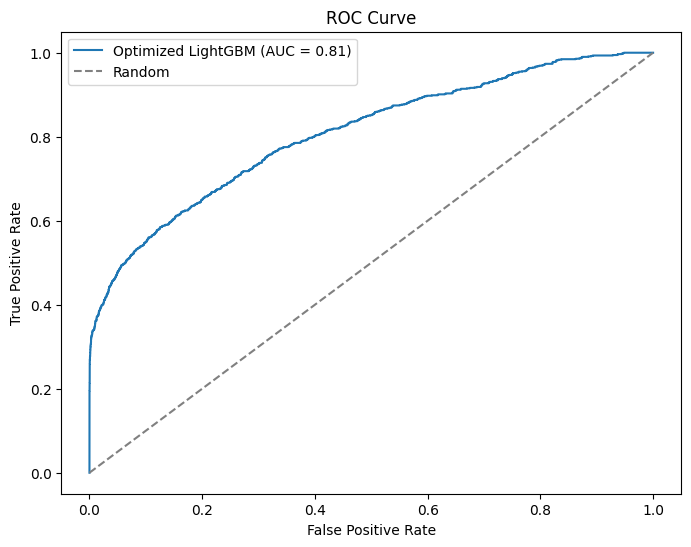

In [ ]:
from sklearn.metrics import roc_curve, auc

# predicting promotion using the optimized model (best_model)
y_pred_proba = best_model.predict_proba(X_test_selected)[:, 1]

# false pos rate, true pos rate, threshold for ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr) # calculating auc (area under the curve)

# plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Optimized LightGBM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random') # random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show() # displaying the plot

## 6. Threshold Optimization before SMOTE

[LightGBM] [Info] Number of positive: 3760, number of negative: 40086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 212
[LightGBM] [Info] Number of data points in the train set: 43846, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

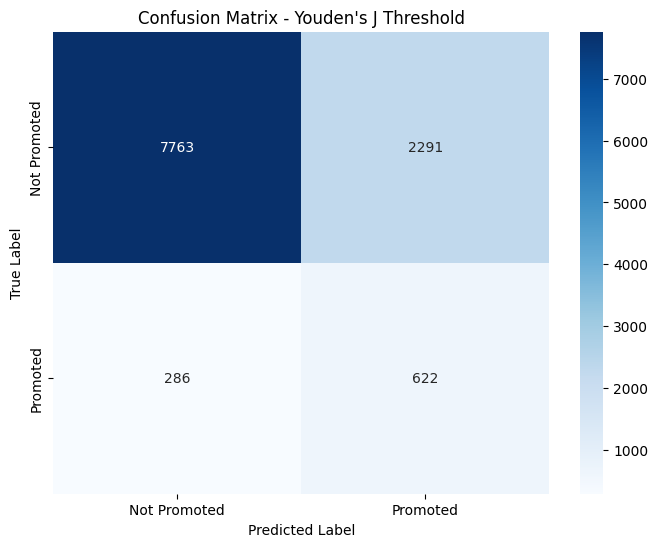


--- Evaluation with Top-Left Corner Threshold (0.4604) (Without SMOTE) ---
Accuracy: 0.7649
Precision: 0.2135
Recall: 0.6850
F1-Score: 0.3256

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.77      0.86     10054
           1       0.21      0.69      0.33       908

    accuracy                           0.76     10962
   macro avg       0.59      0.73      0.59     10962
weighted avg       0.90      0.76      0.81     10962



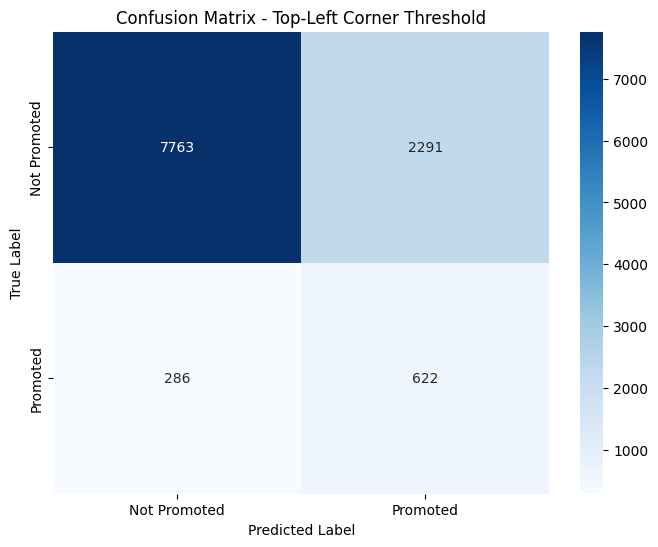


--- Evaluation with F1-Score Threshold (0.7059) (Without SMOTE) ---
Accuracy: 0.9209
Precision: 0.5278
Recall: 0.4284
F1-Score: 0.4729

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     10054
           1       0.53      0.43      0.47       908

    accuracy                           0.92     10962
   macro avg       0.74      0.70      0.72     10962
weighted avg       0.91      0.92      0.92     10962



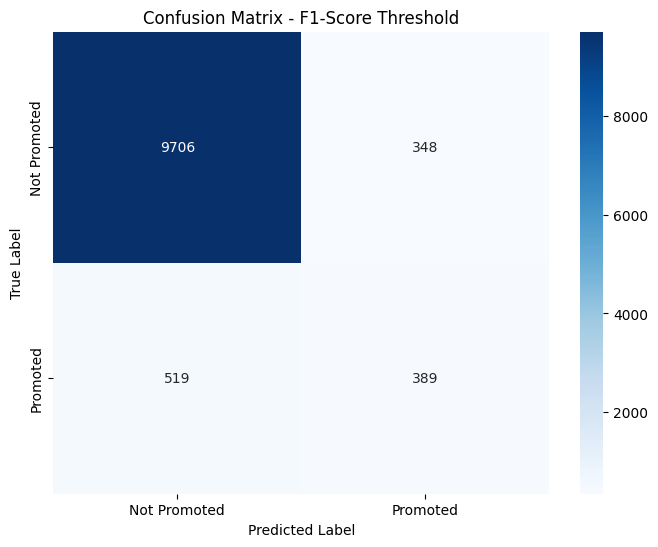


ROC AUC: 0.8050


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# computing class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

# creating dictionary with the class weights
class_weights_dict = dict(enumerate(class_weights))

optimized_lgbm = LGBMClassifier(random_state=42,
                                  **best_params,
                                  class_weight=class_weights_dict)
optimized_lgbm.fit(X_train_selected, y_train) # fit on original training data

y_pred_probs = optimized_lgbm.predict_proba(X_test_selected)[:, 1] # predicting probabilities for promotion

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs) # false pos rate, true pos rate, thresholds

# threshold optimization methods ---
optimal_threshold_youden = thresholds[np.argmax(tpr - fpr)] # Youden's J threshold
distances = np.sqrt((1 - tpr)**2 + fpr**2) # distance to the top-left corner
optimal_idx_top_left = np.argmin(distances) # index of threshold closest to the top-left corner
optimal_threshold_top_left = thresholds[optimal_idx_top_left] # threshold aligning with point in top-left corner

f1_scores = [f1_score(y_test, (y_pred_probs >= thr).astype(int)) for thr in thresholds] # maximizing F1 score
optimal_threshold_f1 = thresholds[np.argmax(f1_scores)] # threshold with max F1 score

def evaluate_with_threshold(threshold, name):
    y_pred = (y_pred_probs >= threshold).astype(int)

    # calculating evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # printing evaluation metrics
    print(f"\n--- Evaluation with {name} Threshold ({threshold:.4f}) (Without SMOTE) ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # generating confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",    # displaying confusion matrix
                xticklabels=['Not Promoted', 'Promoted'],
                yticklabels=['Not Promoted', 'Promoted'])
    plt.title(f"Confusion Matrix - {name} Threshold")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# evaluating with different optimization methods
evaluate_with_threshold(optimal_threshold_youden, "Youden's J")
evaluate_with_threshold(optimal_threshold_top_left, "Top-Left Corner")
evaluate_with_threshold(optimal_threshold_f1, "F1-Score")

# printing ROC AUC score for overall performance insights
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"\nROC AUC: {roc_auc:.4f}")

In [ ]:
!pip install imblearn

[LightGBM] [Info] Number of positive: 40086, number of negative: 40086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2384
[LightGBM] [Info] Number of data points in the train set: 80172, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.914245 -> initscore=2.366608
[LightGBM] [Info] Start training from score 2.366608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7a1fd8eb76d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7a1fd8eb76d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 257, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

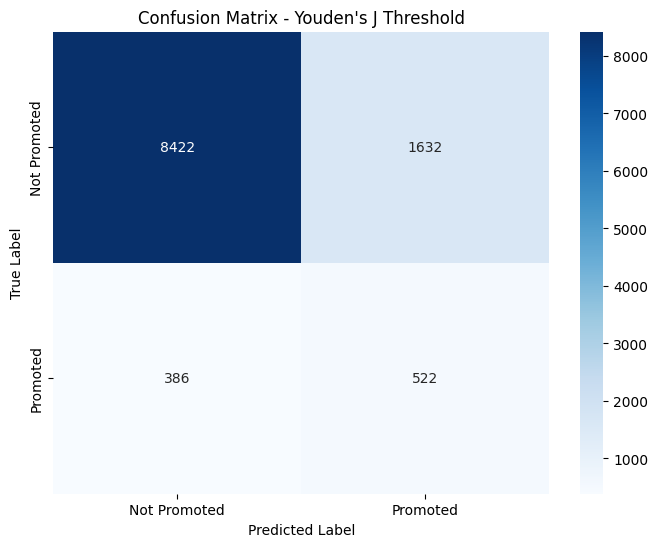


--- Evaluation with Top-Left Corner Threshold (0.7256) (After SMOTE) ---
Accuracy: 0.7708
Precision: 0.2062
Recall: 0.6200
F1-Score: 0.3094

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.78      0.86     10054
           1       0.21      0.62      0.31       908

    accuracy                           0.77     10962
   macro avg       0.58      0.70      0.59     10962
weighted avg       0.90      0.77      0.82     10962



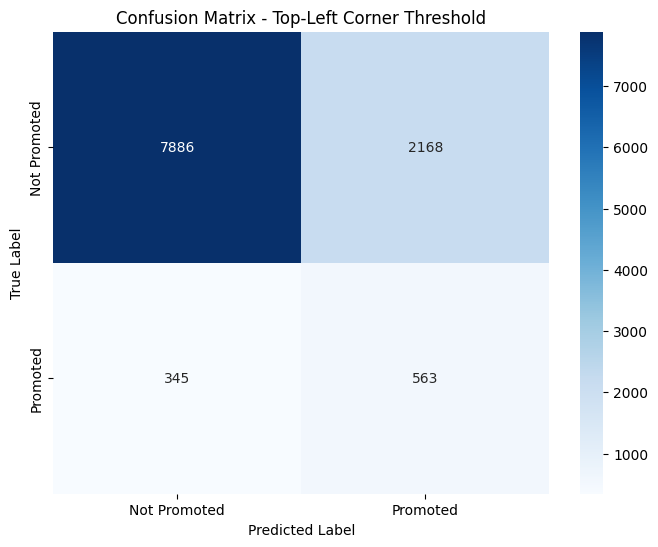


--- Evaluation with F1-Score Threshold (0.8693) (After SMOTE) ---
Accuracy: 0.9094
Precision: 0.4460
Recall: 0.3866
F1-Score: 0.4142

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.95     10054
           1       0.45      0.39      0.41       908

    accuracy                           0.91     10962
   macro avg       0.70      0.67      0.68     10962
weighted avg       0.90      0.91      0.91     10962



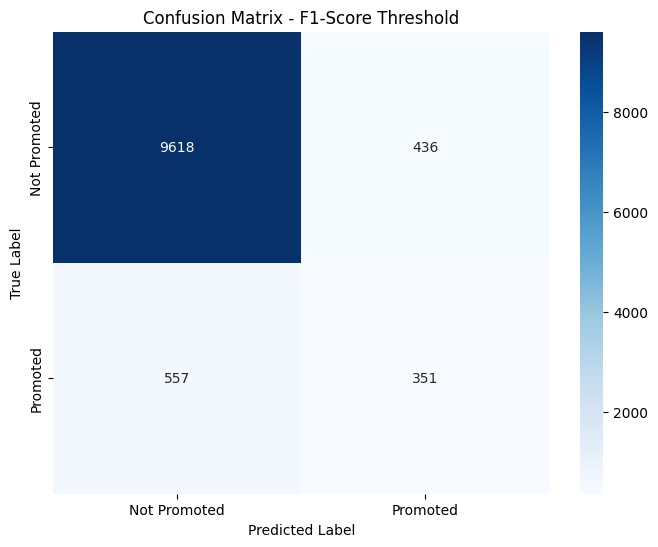


ROC AUC: 0.7720


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils.class_weight import compute_class_weight

# computing class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

# creating dictionary with the class weights
class_weights_dict = dict(enumerate(class_weights))

# smote
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

optimized_lgbm_smote = LGBMClassifier(random_state=42,
                                      **best_params,
                                      class_weight=class_weights_dict)
optimized_lgbm_smote.fit(X_train_resampled, y_train_resampled) # fit on original training data

y_pred_probs = optimized_lgbm_smote.predict_proba(X_test_selected)[:, 1] # predicting probabilities for promotion

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs) # false pos rate, true pos rate, thresholds

# threshold optimization methods ---
optimal_threshold_youden = thresholds[np.argmax(tpr - fpr)] # Youden's J threshold
distances = np.sqrt((1 - tpr)**2 + fpr**2) # distance to the top-left corner
optimal_idx_top_left = np.argmin(distances) # index of threshold closest to the top-left corner
optimal_threshold_top_left = thresholds[optimal_idx_top_left] # threshold aligning with point in top-left corner

f1_scores = [f1_score(y_test, (y_pred_probs >= thr).astype(int)) for thr in thresholds] # maximizing F1 score
optimal_threshold_f1 = thresholds[np.argmax(f1_scores)] # threshold with max F1 score

# evaluation
def evaluate_with_threshold(threshold, name):
    y_pred = (y_pred_probs >= threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n--- Evaluation with {name} Threshold ({threshold:.4f}) (After SMOTE) ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # generating confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", # displaying confusion matrix
                xticklabels=['Not Promoted', 'Promoted'],
                yticklabels=['Not Promoted', 'Promoted'])
    plt.title(f"Confusion Matrix - {name} Threshold")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# evaluating with different optimization methods
evaluate_with_threshold(optimal_threshold_youden, "Youden's J")
evaluate_with_threshold(optimal_threshold_top_left, "Top-Left Corner")
evaluate_with_threshold(optimal_threshold_f1, "F1-Score")

# printing ROC AUC score for overall performance insights
roc_auc = roc_auc_score(y_test, y_pred_probs)
print(f"\nROC AUC: {roc_auc:.4f}")